In [27]:
import torch
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Forward Diffusion

In [45]:

def linear_beta_schedule(timesteps: int, start: float = 0.0001, end: float = 0.02):
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals: torch.tensor, t: torch.tensor, x_shape: tuple):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion(x_0, t, device="cpu"):
    """
    Takes an image and a timestep t as input and returns the noisy version of the image
    """

    # noise from normal distribution like x_0
    noise = torch.randn_like(x_0, device=device)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return (
        sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise
    ), noise


T = 200
betas = linear_beta_schedule(timesteps=T)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# pad the last dimention only on one side (1, 0) with value 1.0
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)


sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variancee = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


## Dataloader

In [59]:
import os
from PIL import Image

class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform = None):
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image[None]

In [60]:
IMG_SIZE=64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t*2) - 1) #scale between [-1, 1] - scale to (0, 2) then -1 to get [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_root_path = "/Users/mo/Projects/datasets/stanford_cars/train/cars_train"
    test_root_path = "/Users/mo/Projects/datasets/stanford_cars/test/cars_test"
    train = StanfordCars(root_path=train_root_path, transform=data_transform)
    test = StanfordCars(root_path=test_root_path, transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test]) #Combine all images


def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t+1)/2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t*255. ),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

    if (len(image.shape)) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transform(image))
    

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/var/folders/z4/xc1539lx0lvdg8mnss_700nc0000gn/T/ipykernel_50214/3524023569.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, (idx//stepsize)+ 1)


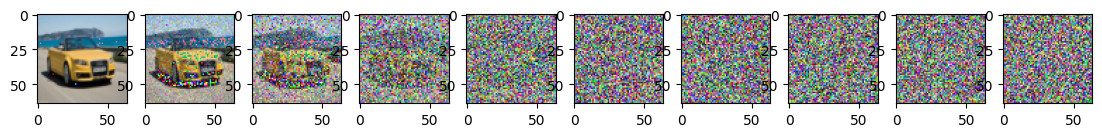

In [63]:
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.axis('off')

num_images = 10
stepsize = int(T/ num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx//stepsize)+ 1)
    image, noise = forward_diffusion(image, t)
    show_tensor_image(image)